In [69]:
import sys
sys.path.append('/content/drive/MyDrive/Operational_risk/modules')

In [70]:
import adf
import granger_diff
import granger
import graphs
import hill_plot
import l1_l2_gpd
import pruning

#Finance

In [71]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy

#############################################
# 1. 데이터 전처리
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.
sasop_path = '/content/drive/MyDrive/sasop.xlsx'
# 손실 데이터 (미국 사건만 선택)
df1 = pd.read_excel(sasop_path)



In [103]:
df=df1.copy()

In [104]:
us_df = df[df['Country of Incident'] == 'United States']
loss_df = us_df[['First Year of Event','Industry Sector Code','Basel Business Line - Level 2','Event Risk Category','Current Value of Loss ($M)']].copy()
loss_df.rename(columns={'First Year of Event':'Date', 'Current Value of Loss ($M)':'Current Value of Loss'}, inplace=True)
loss_df['Date'] = pd.to_datetime(loss_df['Date']).dt.strftime('%Y')
loss_df.sort_values(by='Date', inplace=True)
loss_df = loss_df[loss_df['Date'] >= '1979']


In [105]:
loss_df_finance=loss_df[(loss_df['Industry Sector Code']==52)]

In [106]:
np.shape(loss_df_finance)

(11115, 5)

In [107]:
loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)

<ipython-input-107-99083bedbca1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.rename(columns={"Basel Business Line - Level 2":"Business"},inplace=True)


In [108]:
loss_df_finance.head()

,Date,Industry Sector Code,Business,Event Risk Category,Current Value of Loss
1799,1979,52,Commercial Banking,"Clients, Products & Business Practices",8.844700
4667,1979,52,Professional Liability/Fidelity Coverage,"Clients, Products & Business Practices",4.219065
1282,1979,52,Retail Banking,Internal Fraud,2.304687
1654,1979,52,Commercial Banking,Internal Fraud,12.408634
1707,1979,52,Commercial Banking,"Clients, Products & Business Practices",6.328597


In [109]:
# loss_df_finance=loss_df_finance[['Date','Event Risk Category','Current Value of Loss']]

In [110]:
loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)

<ipython-input-110-825df21b5a50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_finance.drop(columns=['Industry Sector Code'],inplace=True)


In [111]:
loss_df_finance.head()

,Date,Business,Event Risk Category,Current Value of Loss
1799,1979,Commercial Banking,"Clients, Products & Business Practices",8.844700
4667,1979,Professional Liability/Fidelity Coverage,"Clients, Products & Business Practices",4.219065
1282,1979,Retail Banking,Internal Fraud,2.304687
1654,1979,Commercial Banking,Internal Fraud,12.408634
1707,1979,Commercial Banking,"Clients, Products & Business Practices",6.328597


In [112]:
# Encode 'Event Risk Category'
df_encoded_a = pd.get_dummies(loss_df_finance, columns=['Event Risk Category'], prefix='Category')



In [113]:
# Use the result of the first encoding as input for the second encoding
df_encoded_b = pd.get_dummies(df_encoded_a, columns=['Business'], prefix='Category')

# Final encoded DataFrame
loss_df_finance = df_encoded_b.copy()


In [114]:
loss_df_finance.head()

,Date,Current Value of Loss,Category_Business Disruption and System Failures,"Category_Clients, Products & Business Practices",Category_Damage to Physical Assets,Category_Employment Practices and Workplace Safety,"Category_Execution, Delivery & Process Management",Category_External Fraud,Category_Internal Fraud,Category_Advisory Services,...,Category_Others,Category_Private Banking,Category_Professional Liability/Fidelity Coverage,Category_Property and Casualty Insurance,Category_Proprietary Positions,Category_Reinsurance,Category_Retail Banking,Category_Retail Brokerage,Category_Sales,Category_Treasury
1799,1979,8.844700,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4667,1979,4.219065,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1282,1979,2.304687,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1654,1979,12.408634,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1707,1979,6.328597,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [115]:
np.shape(loss_df_finance)

(11115, 35)

In [116]:
import pandas as pd
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
#us_vix = pd.read_csv(file_paths["us_vix"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns for consistency
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
#us_vix.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500=sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])
# 1) Date 컬럼을 년(YYYY)으로만 변환
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500]:
    # 바깥에서 "Date" 컬럼 명으로 통일
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year  # 년도로만 추출

# 2) 연 단위 집계: "마지막 값" or "평균" 등 선택
#   여기서는 예시로 평균값 사용
us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
#us_vix = us_vix.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()

us_cpi['CPI_diff']=np.log(us_cpi['CPI']).diff()
us_home_price['House Price Index_diff']=np.log(us_home_price['House Price Index']).diff()
sp500['Close_diff']=np.log(sp500['Close']).diff()
sp500.fillna(0.1635259493925565,inplace=True)

# 3) 머지
dfs = [us_T10Y2Y, us_home_price, us_m1,  us_cpi, us_unemp, sp500]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


df_merged_macro_lag=df_merged_macro.copy()
df_merged_macro_lag = df_merged_macro_lag[df_merged_macro_lag["Date"] >= 1980]
df_merged_macro_lag['Date']=df_merged_macro_lag['Date'].astype(str)

In [117]:
import pandas as pd
import numpy as np
from functools import reduce

file_paths = {
    "us_cpi": "/content/drive/MyDrive/us_cpi.csv",
    "us_unemp": "/content/drive/MyDrive/us_unemp.csv",
    "us_vix": "/content/drive/MyDrive/us_vix.csv",
    "us_m1": "/content/drive/MyDrive/us_m1.csv",
    "us_home_price": "/content/drive/MyDrive/us_home price index.csv",
    "us_T10Y2Y": "/content/drive/MyDrive/us_T10Y2Y.csv",
    "sp500": "/content/drive/MyDrive/sp500_monthly.csv",
}

# Load
us_cpi = pd.read_csv(file_paths["us_cpi"])
us_unemp = pd.read_csv(file_paths["us_unemp"])
us_m1 = pd.read_csv(file_paths["us_m1"])
us_home_price = pd.read_csv(file_paths["us_home_price"])
us_T10Y2Y = pd.read_csv(file_paths["us_T10Y2Y"])
sp500 = pd.read_csv(file_paths["sp500"], skiprows=2)

# Rename columns
us_T10Y2Y.rename(columns={'T10Y2Y': '10_2'}, inplace=True)
us_home_price.rename(columns={'USSTHPI': 'House Price Index'}, inplace=True)
us_m1.rename(columns={'WM1NS': 'M1'}, inplace=True)
us_cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
us_unemp.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)
sp500.rename(columns={'Unnamed: 1': 'Close'}, inplace=True)
sp500 = sp500.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5"])

# Date 처리 및 연 단위 평균
for df in [us_cpi, us_unemp, us_m1, us_home_price, us_T10Y2Y, sp500]:
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.year

us_T10Y2Y = us_T10Y2Y.groupby("Date").mean().reset_index()
us_home_price = us_home_price.groupby("Date").mean().reset_index()
us_m1 = us_m1.groupby("Date").mean().reset_index()
us_cpi = us_cpi.groupby("Date").mean().reset_index()
us_unemp = us_unemp.groupby("Date").mean().reset_index()
sp500 = sp500.groupby("Date").mean().reset_index()

# log-diff 처리
macro_dfs = {
    'CPI_diff': (us_cpi, 'CPI'),
    'House Price Index_diff': (us_home_price, 'House Price Index'),
    'M1_diff': (us_m1, 'M1'),
    '10_2_diff': (us_T10Y2Y, '10_2'),
    'Unemployment Rate_diff': (us_unemp, 'Unemployment Rate'),
    'Close_diff': (sp500, 'Close'),
}

# diff 열 추가
for diff_col, (df, col) in macro_dfs.items():
    df[diff_col] = np.log(df[col]).diff()

# sp500의 첫 번째 NaN만 특정 값으로 채움
sp500['Close_diff'].fillna(0.1635259493925565, inplace=True)

# 병합
dfs = [us_T10Y2Y, us_home_price, us_m1, us_cpi, us_unemp, sp500]
df_merged_macro = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)

# 최종 lag 데이터
df_merged_macro_lag = df_merged_macro[df_merged_macro["Date"] >= 1980].copy()
df_merged_macro_lag['Date'] = df_merged_macro_lag['Date'].astype(str)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-117-b81c95cc248a>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sp500['Close_diff'].fillna(0.1635259493925565, inplace=True)


In [118]:
df_merged_macro_lag.head()

,Date,10_2,10_2_diff,House Price Index,House Price Index_diff,M1,M1_diff,CPI,CPI_diff,Unemployment Rate,Unemployment Rate_diff,Close,Close_diff
0,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.085960,107.600000,0.034671,7.191667,-0.043091,188.966668,0.163526
1,1986,0.812360,-0.509468,136.3500,0.066070,666.057692,0.126388,109.691667,0.019253,7.000000,-0.027013,238.920832,0.234562
2,1987,0.977040,0.184584,145.1750,0.062715,743.517308,0.110016,113.616667,0.035157,6.175000,-0.125401,285.991665,0.179830
3,1988,0.747600,-0.267660,152.9675,0.052286,774.346154,0.040627,118.275000,0.040182,5.491667,-0.117277,268.050835,-0.064786
4,1989,-0.078680,NaN,161.0375,0.051412,782.015385,0.009855,123.941667,0.046799,5.258333,-0.043418,326.314163,0.196684


In [119]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from scipy.stats import genpareto
import copy
#1986부터 사용
#############################################
# 1. 데이터 전처리 (연 단위)
#############################################
# (1) 엑셀 파일 읽기 및 날짜 정리
# 실제 파일 경로로 수정하세요.

epu_kr_path = '/content/drive/MyDrive/Korea_Overall_EPU.xlsx'
epu_kr_cat_path = '/content/drive/MyDrive/Korea_Categorical_PU_Indices.xlsx'
epu_usa_path = '/content/drive/MyDrive/US_Policy_Uncertainty_Data.xlsx'
epu_usa_cat_path = '/content/drive/MyDrive/Categorical_EPU_Data.xlsx'


# 미국 EPU 데이터
epu_usa = pd.read_excel(epu_usa_path)
epu_usa_cat = pd.read_excel(epu_usa_cat_path)
# 연도만 추출 (datetime 변환 후 정수형으로)
epu_usa['Year'] = pd.to_datetime(epu_usa['Year'], format='%Y').dt.year.astype(int)
epu_usa_cat['Year'] = pd.to_datetime(epu_usa_cat['Year'], format='%Y').dt.year.astype(int)
# 연도 필터링 (1985~2022)
epu_usa_cl = epu_usa[(epu_usa['Year'] < 2023)].copy()
epu_usa_cat_cl = epu_usa_cat[ (epu_usa_cat['Year'] < 2023)].copy()
# 최종적으로 'Date' 컬럼에 연도만(문자형) 저장
epu_usa_cl['Date'] = epu_usa_cl['Year'].astype(str)
epu_usa_cat_cl['Date'] = epu_usa_cat_cl['Year'].astype(str)
epu_usa_cl_lag = epu_usa_cl.copy()
epu_usa_cat_cl_lag = epu_usa_cat_cl.copy()

# (2) 여러 DataFrame 병합 (Date 기준 inner merge)
dfs = [df_merged_macro_lag,epu_usa_cl,epu_usa_cat_cl, loss_df_finance]
df_merged = reduce(lambda left, right: pd.merge(left, right, on="Date", how="inner"), dfs)


# 불필요하게 많이 생긴 NaN forward fill 등 (선택)
df_merged.sort_values("Date", inplace=True)
df_merged.fillna(method='ffill', inplace=True)

# 2) 극단값 분석용 상위 90% 초과치
# tau = df_merged['Current Value of Loss'].quantile(0.90)
# df_merged = df_merged[df_merged['Current Value of Loss'] > tau].copy()
df_merged['Exceedance'] = df_merged['Current Value of Loss']


<ipython-input-119-d455ab0656e8>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)


In [120]:
df_merged.head()

,Date,10_2,10_2_diff,House Price Index,House Price Index_diff,M1,M1_diff,CPI,CPI_diff,Unemployment Rate,...,Category_Private Banking,Category_Professional Liability/Fidelity Coverage,Category_Property and Casualty Insurance,Category_Proprietary Positions,Category_Reinsurance,Category_Retail Banking,Category_Retail Brokerage,Category_Sales,Category_Treasury,Exceedance
0,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,True,False,False,False,29.172714
9881,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,True,False,False,False,False,False,False,4.225260
9882,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,14.404295
9883,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,10.813796
9884,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,11.523436


In [121]:
# 1) 전체 EPU 연평균 집계
# ————————
# epu_usa_cl 은 Year, Month, Three_Component_Index, News_Based_Policy_Uncert_Index 컬럼 보유
epu_usa_cl['Date'] = epu_usa_cl['Year'].astype(str)

epu_overall = (
    epu_usa_cl
    .groupby('Date')[['Three_Component_Index','News_Based_Policy_Uncert_Index']]
    .mean()
    .reset_index()
)

# 2) 범주형 EPU 연평균 집계
# ————————
cat_cols = [
    '1. Economic Policy Uncertainty','2. Monetary policy',
    'Fiscal Policy (Taxes OR Spending)','3. Taxes',
    '4. Government spending','5. Health care',
    '6. National security','7. Entitlement programs',
    '8. Regulation','Financial Regulation',
    '9. Trade policy','10. Sovereign debt, currency crises'
]
epu_usa_cat_cl['Date'] = epu_usa_cat_cl['Year'].astype(str)

epu_cats = (
    epu_usa_cat_cl
    .groupby('Date')[cat_cols]
    .mean()
    .reset_index()
)

# 3) 매크로 + EPU(전체+범주) 병합
# ———————————————
df_macro_epu = (
    df_merged_macro_lag
    .merge(epu_overall, on='Date', how='inner')
    .merge(epu_cats,    on='Date', how='inner')
)

# 4) 최종: 이벤트 손실(≈433행)과 1:1 병합
# ——————————————————————
final_df = df_macro_epu.merge(loss_df_finance, on='Date', how='inner')

print(final_df.shape)  # → (≈433, 원하는 컬럼만)


(10698, 61)


In [122]:
df_merged=final_df.copy()
df_merged['Exceedance']=df_merged['Current Value of Loss']

In [123]:
np.shape(df_merged)

(10698, 62)

#hill plot

In [93]:
u, k, g, diag = hill_plot.select_threshold(
    df_merged['Exceedance'],
    k_min=10, min_excess=10,
    return_diag=True
)



In [94]:
u,k,g

(191.819728304947, 558, np.float64(1.1002278205711957))

#Trainning

In [95]:
if __name__ == "__main__":

    # --- Configuration ---
    TARGET_VARIABLE = "Exceedance"
    DATE_COLUMN = "Date"
    START_YEAR = 1985

    # Granger Test based lags (example)
    selected_lags_dict = {
        'Three_Component_Index': [1],
        'News_Based_Policy_Uncert_Index': [1],
        "1. Economic Policy Uncertainty": [1],
        '2. Monetary policy': [2],
        "Fiscal Policy (Taxes OR Spending)": [1],
        "3. Taxes": [1],
        "5. Health care": [1],
        "6. National security": [1],
        "7. Entitlement programs": [1],
        "8. Regulation": [1],
        "Financial Regulation": [1],
        "9. Trade policy": [2],
        "10. Sovereign debt, currency crises": [3],
        "House Price Index_diff": [2],
        "CPI_diff": [2],
        "Close_diff": [2]
    }

    # Categorical features (assumed to be 0/1 dummy encoded)
    categorical_cols_list = [
        'Category_Business Disruption and System Failures',
        'Category_Clients, Products & Business Practices',
        'Category_Damage to Physical Assets',
        'Category_Employment Practices and Workplace Safety',
        'Category_Execution, Delivery & Process Management',
        'Category_External Fraud', 'Category_Internal Fraud',
        'Category_Commercial Banking', 'Category_Corporate Finance',
        'Category_Health Insurance',
        'Category_Life Insurance and Benefit Plans',
        'Category_Merchant Banking', 'Category_Municipal/Government Finance',
        'Category_Private Banking', 'Category_Property and Casualty Insurance',
        'Category_Reinsurance', 'Category_Retail Banking'
    ]

    # --- Data Loading and Preparation ---
    # Placeholder: Load your actual data into 'df_merged' pandas DataFrame
    # Example: df_merged = pd.read_csv("your_data.csv")
    # For demonstration, we'll use placeholder random data if 'df_merged' isn't found.

    if 'df_merged' not in locals() or not isinstance(df_merged, pd.DataFrame):
        l1_l2_gpd.logging.warning("'df_merged' DataFrame not found. Generating synthetic data.")
        # Create synthetic data matching the structure expected
        n_years = 40
        dates = pd.date_range(start=f'{1980}-01-01', periods=n_years, freq='YS')
        data = {'Date': dates}
        # Add columns from lag config and categoricals
        all_needed_cols = list(selected_lags_dict.keys()) + categorical_cols_list + [TARGET_VARIABLE]
        for col in all_needed_cols:
             if col == TARGET_VARIABLE: # Make target positive, Pareto-like
                  data[col] = np.random.pareto(a=1.5, size=n_years) * 1000 + 1
             elif col.startswith("Category_"): # Binary categorical
                  data[col] = np.random.randint(0, 2, size=n_years)
             else: # Other predictors (random walk like)
                  data[col] = np.random.randn(n_years).cumsum() + 100

        df_merged = pd.DataFrame(data)


    # Create the dataset with lagged features
    try:
        df_model_ready, feature_names_list = l1_l2_gpd.create_lagged_features(
            df=df_merged,
            target_col=TARGET_VARIABLE,
            lag_config=selected_lags_dict,
            date_col=DATE_COLUMN,
            start_year=START_YEAR,
            additional_features=categorical_cols_list
        )
    except Exception as e:
        l1_l2_gpd.logging.error(f"Error creating lagged features: {e}")
        # Handle error, maybe exit or use fallback data
        raise # Re-raise the exception to stop execution

    if df_model_ready.empty:
        l1_l2_gpd.logging.error("Resulting DataFrame is empty after processing. Check input data and parameters.")
    else:
        X_all_data = df_model_ready[feature_names_list].values
        y_all_data = df_model_ready[TARGET_VARIABLE].values


        u_threshold=191
        #3500
        mask_bulk = y_all_data <= u_threshold
        mask_tail = ~mask_bulk

        X_bulk, y_bulk = X_all_data[mask_bulk], y_all_data[mask_bulk]
        # For GPD, fit excesses: y_tail = y_observed - u
        X_tail, y_tail = X_all_data[mask_tail], y_all_data[mask_tail] - u_threshold

        l1_l2_gpd.logging.info(f"Data split: Bulk = {len(y_bulk)} samples, Tail (Excesses) = {len(y_tail)} samples.")

        # Check if tail data is sufficient
        MIN_TAIL_SAMPLES = 50 # Minimum samples needed to reliably fit GPD tree
        if len(y_tail) < MIN_TAIL_SAMPLES:
             l1_l2_gpd.logging.warning(f"Tail dataset size ({len(y_tail)}) is small. GPD results may be unreliable.")
             # Consider alternative: Don't fit GPD tree, maybe use LogNormal for tail too, or simpler model.
             # For now, we proceed but with caution.

        # --- Model Fitting ---


        # 1) L1 CART (Median) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L1 CART (Median) for Bulk Data...")
        l1_bulk_tree = l1_l2_gpd.grow_tree_l1(X_bulk, y_bulk, feature_names_list, min_leaf=20, max_depth=3)
        l1_l2_gpd.assign_lognorm_params(l1_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)

        print("\n===== L1 CART (Bulk, Median-based) =====")
        l1_l2_gpd.print_tree_structure(l1_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l1_bulk_tree)


        # 2) L2 CART (Mean) + LogNormal for Bulk
        l1_l2_gpd.logging.info("Fitting L2 CART (Mean) for Bulk Data...")
        l2_bulk_tree = l1_l2_gpd.grow_tree_l2(X_bulk, y_bulk, feature_names_list, min_leaf=30, max_depth=4)
        l1_l2_gpd.assign_lognorm_params(l2_bulk_tree, X_bulk, y_bulk, trunc_left=u_threshold)
        print("\n===== L2 CART (Bulk, Mean-based) =====")
        l1_l2_gpd.print_tree_structure(l2_bulk_tree, feature_names_list)
        l1_l2_gpd.validate_tree_structure(l2_bulk_tree)

        # 3) GPD CART for Tail (Excesses)
        gpd_tail_tree_pruned = None
        if len(y_tail) >= MIN_TAIL_SAMPLES: # Only fit if enough tail data
            l1_l2_gpd.logging.info("Fitting GPD CART for Tail Data (Excesses)...")
            # Grow initial large tree
            gpd_tail_tree_raw = l1_l2_gpd.grow_tree_gpd(X_tail, y_tail, feature_names_list, min_leaf=15, max_depth=4) # Grow deeper initially

            print("\n===== Raw GPD CART (Tail, Excesses) =====")
            l1_l2_gpd.print_tree_structure(gpd_tail_tree_raw, feature_names_list)

            # Prune using CV
            l1_l2_gpd.logging.info("Pruning GPD CART using Cross-Validation...")
            try:
                # Adjust n_folds based on tail data size
                cv_folds = min(5, max(2, len(y_tail) // 10))
                gpd_tail_tree_pruned, best_alpha_gpd = l1_l2_gpd.prune_gpd_with_cv(gpd_tail_tree_raw, X_tail, y_tail, n_folds=cv_folds)
                l1_l2_gpd.logging.info(f"GPD CART Pruning complete. Best alpha = {best_alpha_gpd:.4g}")

                print("\n===== Pruned GPD CART (Tail, Excesses) =====")
                l1_l2_gpd.print_tree_structure(gpd_tail_tree_pruned, feature_names_list)
                l1_l2_gpd.validate_tree_structure(gpd_tail_tree_pruned, min_samples_leaf=10) # Check pruned tree
            except Exception as e:
                 l1_l2_gpd.logging.error(f"GPD Tree Pruning failed: {e}. Using raw tree.")
                 gpd_tail_tree_pruned = gpd_tail_tree_raw # Fallback to raw tree

        else:
            l1_l2_gpd.logging.warning("Skipping GPD CART fitting due to insufficient tail data.")

        l1_l2_gpd.logging.info("Script finished.")



===== L1 CART (Bulk, Median-based) =====
[Category_Clients, Products & Business Practices ≤ 0.5] (Gain=3466.325) N=10136
  [9. Trade policy_lag2 ≤ 77.88] (Gain=694.990) N=5181
    [Category_Commercial Banking ≤ 0.5] (Gain=297.159) N=4051
      Leaf: N=3388, median=1.02, LN(mu=4.59, sigma=4.95)
      Leaf: N=663, median=3.05, LN(mu=4.78, sigma=4.09)
    [6. National security_lag1 ≤ 80.47] (Gain=136.964) N=1130
      Leaf: N=567, median=2.72, LN(mu=4.77, sigma=4.30)
      Leaf: N=563, median=5.53, LN(mu=4.91, sigma=3.59)
  [News_Based_Policy_Uncert_Index_lag1 ≤ 121.7] (Gain=1084.499) N=4955
    [6. National security_lag1 ≤ 49.52] (Gain=350.657) N=3018
      Leaf: N=762, median=5.62, LN(mu=4.99, sigma=3.84)
      Leaf: N=2256, median=10.37, LN(mu=5.04, sigma=3.34)
    [2. Monetary policy_lag2 ≤ 122.4] (Gain=191.472) N=1937
      Leaf: N=1350, median=2.95, LN(mu=4.86, sigma=4.39)
      Leaf: N=587, median=6.48, LN(mu=5.02, sigma=3.89)

===== L2 CART (Bulk, Mean-based) =====
[Category_Clie

In [96]:
graphs.gp_tree_lrt(gpd_tail_tree_pruned, X_tail, y_tail)

GP 트리 vs 단일 GP 적합 LRT 결과:
  GP 트리 로그우도 합: -4169.94
  단일 GP 로그우도: -4160.56
  LRT statistic = -18.76 (df = 4)
  p‑value = 1.000e+00 -> fail to reject single GP model
  AIC (GP 트리) = 8351.87, AIC (단일 GP) = 8325.11


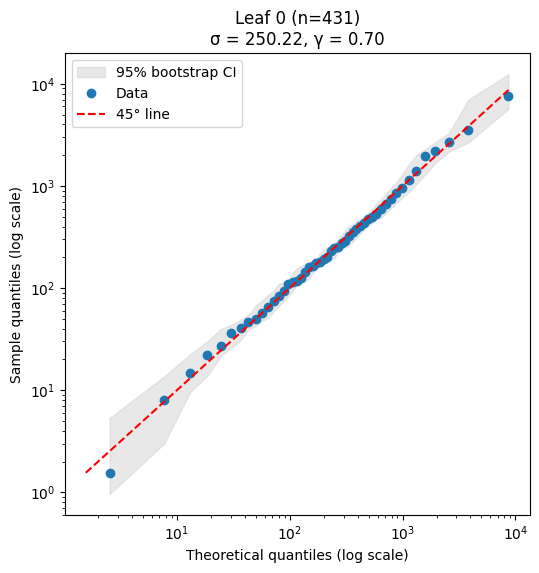

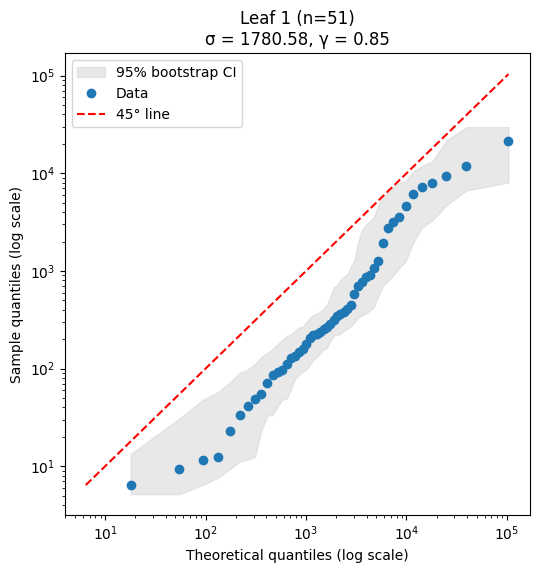

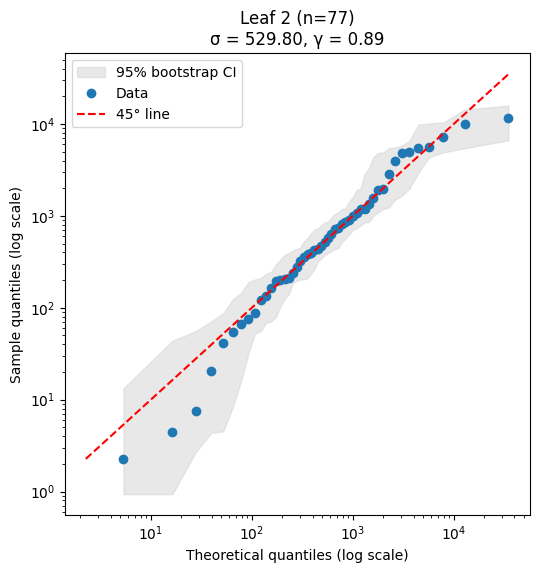

In [97]:
graphs.plot_gp_tree_qq(gpd_tail_tree_pruned, X_tail, y_tail)


In [98]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    # Bulk 트리
    'l1_bulk_tree' : l1_bulk_tree,
    'l2_bulk_tree' : l2_bulk_tree,
    # Tail 트리
    'gpd_raw_tree' : gpd_tail_tree_raw,
    'gpd_pruned_tree' : gpd_tail_tree_pruned,
    # 데이터
    'X_bulk'       : X_bulk,
    'y_bulk'       : y_bulk,
    'X_tail'       : X_tail,
    'y_tail'       : y_tail,
    'X_all_data'   : X_all_data,
    'y_all_data'   : y_all_data,
    'df_model_ready':df_model_ready,
    # (선택) 피처 이름
    'feature_names': feature_names_list,
    # (선택) 임계값
    'u_threshold'  : u_threshold
}

# 2) 피클 파일로 저장
with open(save_path + 'risk_1985_2021_fixed.pkl', 'wb') as f:
    pickle.dump(output, f)

l1_l2_gpd.logging.info("Models and data have been saved to 'risk_1985_2021_fixed.pkl'")


In [99]:
df_merged.head()

,Date,10_2,10_2_diff,House Price Index,House Price Index_diff,M1,M1_diff,CPI,CPI_diff,Unemployment Rate,...,Category_Private Banking,Category_Professional Liability/Fidelity Coverage,Category_Property and Casualty Insurance,Category_Proprietary Positions,Category_Reinsurance,Category_Retail Banking,Category_Retail Brokerage,Category_Sales,Category_Treasury,Exceedance
0,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,True,False,False,False,29.172714
1,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,True,False,False,False,60.776487
2,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,True,False,False,187.426355
3,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,127.310272
4,1985,1.352097,0.540128,127.6325,0.049817,586.978846,0.08596,107.6,0.034671,7.191667,...,False,False,False,False,False,False,False,False,False,2.488805


In [100]:
import pickle

# --- __main__ 블록 마지막에 추가 ---
save_path = '/content/drive/MyDrive/Operational_risk/'
# 1) 저장할 객체들 모으기
output = {
    'df_merged':df_merged
}

# 2) 피클 파일로 저장
with open(save_path + 'df_merged.pkl', 'wb') as f:
    pickle.dump(output, f)




#Premium